# Re-Training a Densenet Base model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 63.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
import torchmetrics
import lightning as L
import numpy as np
import matplotlib.pyplot as plt
import os
import collections
import pandas as pd
import seaborn as sns

In [4]:
mean = np.array([0.6760, 0.6308, 0.5746])
std = np.array([0.2055, 0.2108, 0.2250])

data_dir = 'drive/MyDrive/garbage'
sets = ['TRAIN', 'TEST']

In [5]:
data_transforms = {
    'TRAIN':transforms.Compose([
        transforms.Resize(size=(150, 300)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    'TEST':transforms.Compose([
        transforms.Resize(size=(150, 300)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
}

In [ ]:
# Again, let's exclude the burnables to get a more evenly balanced dataset

In [6]:
class FilteredImageFolder(datasets.ImageFolder):
    def __init__(self, root, exclude_folder=None, transform=None):
        self.exclude_folder = exclude_folder
        # Filter out the excluded folder before initializing the parent class
        all_classes, class_to_idx = self.find_classes(root)
        if exclude_folder and exclude_folder in class_to_idx:
            del class_to_idx[exclude_folder]
            all_classes.remove(exclude_folder)
        self.filtered_classes = all_classes
        self.filtered_class_to_idx = class_to_idx
        super(FilteredImageFolder, self).__init__(root, transform=transform)
        # Re-filter samples after the parent initialization to match updated class_to_idx
        if exclude_folder:
            self.samples = [s for s in self.samples if exclude_folder not in s[0]]
            self.targets = [self.filtered_class_to_idx[self.classes[s[1]]] for s in self.samples]
            self.classes = self.filtered_classes
            self.class_to_idx = self.filtered_class_to_idx

    def find_classes(self, directory):
        """Finds the class folders in a dataset.

        Args:
            directory (string): Root directory path.

        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (directory), and class_to_idx is a dictionary.
        """
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir() and entry.name !="burnable")
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx


In [7]:
dataset = FilteredImageFolder(os.path.join(data_dir, sets[0]), exclude_folder='burnable', transform=data_transforms['TRAIN'])
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], generator=generator)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))


19071
2384
2383


In [8]:
dataset.class_to_idx

{'PET': 0,
 'books_and_paper': 1,
 'cans': 2,
 'cardboard': 3,
 'clothes': 4,
 'danger': 5,
 'glass_bin': 6,
 'metal': 7,
 'nonburn': 8,
 'plastic': 9}

In [9]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=32, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, shuffle=False, batch_size=32, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, shuffle=False, batch_size=32, num_workers=2)

In [ ]:
model = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.DEFAULT)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 204MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
model.features

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 128, ke

In [ ]:
model.classifier

Linear(in_features=1024, out_features=1000, bias=True)

In [10]:
class GarbageModel(L.LightningModule):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        base_model = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.DEFAULT)
        # check number of features input to final linear layer of model
        num_features = base_model.classifier.in_features
        base_model.classifier = torch.nn.Linear(in_features=num_features, out_features=num_classes)
        for param in base_model.features.parameters(): # freeze all the model parameters in the features part
          param.requires_grad = False
        self.model = base_model
        self.num_classes = num_classes
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes)
        self.precision = torchmetrics.classification.MulticlassPrecision(num_classes=num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def _commmon_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss_function(logits, y)
        return loss, logits, y

    def training_step(self, batch, batch_idx):
      loss, logits, y = self._commmon_step(batch, batch_idx)
      accuracy = self.accuracy(logits, y)
      precision = self.precision(logits, y)
      self.log_dict({'training_loss':loss, 'training_accuracy': accuracy, 'training_precision': precision})
      return loss

    def validation_step(self, batch, batch_idx):
      loss, logits, y = self._commmon_step(batch, batch_idx)
      accuracy = self.accuracy(logits, y)
      precision = self.precision(logits, y)
      self.log_dict({'validation_loss':loss, 'validation_accuracy': accuracy, 'validation_precision': precision})
      return loss

    def test_step(self, batch, batch_idx):
      loss, logits, y = self._commmon_step(batch, batch_idx)
      accuracy = self.accuracy(logits, y)
      precision = self.precision(logits, y)
      self.log_dict({'test_loss':loss, 'test_accuracy': accuracy, 'test_precision': precision})
      return loss

    def predict_step(self, batch, batch_idx):
      x, y = batch
      logits = self.forward(x)
      preds = torch.argmax(logits, dim=1)
      return preds

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
      scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)
      return [optimizer], [scheduler]

In [11]:
model = GarbageModel(num_channels=3, num_classes=10)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 203MB/s]


In [12]:
csv_logger = L.pytorch.loggers.CSVLogger('drive/MyDrive/garbage/densenet_noburn_logs')

In [13]:
trainer = L.Trainer(accelerator='auto', max_epochs=10, logger=csv_logger)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more det

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [14]:
results = trainer.test(model, dataloaders=test_dataloader)
results

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8546209931373596     │
│         test_loss         │    0.38731861114501953    │
│      test_precision       │     0.853862464427948     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.38731861114501953,
  'test_accuracy': 0.8546209931373596,
  'test_precision': 0.853862464427948}]

In [15]:
import pandas as pd
import seaborn as sns

In [16]:
csv_file_path = 'drive/MyDrive/garbage/densenet_noburn_logs/lightning_logs/version_0/metrics.csv'
metrics_df = pd.read_csv(csv_file_path)
metrics_df.tail()

,epoch,step,test_accuracy,test_loss,test_precision,training_accuracy,training_loss,training_precision,validation_accuracy,validation_loss,validation_precision
125,9,5849,NaN,NaN,NaN,0.789683,0.482039,0.796296,NaN,NaN,NaN
126,9,5899,NaN,NaN,NaN,0.890909,0.344433,0.907143,NaN,NaN,NaN
127,9,5949,NaN,NaN,NaN,0.852381,0.222980,0.866667,NaN,NaN,NaN
128,9,5959,NaN,NaN,NaN,NaN,NaN,NaN,0.831128,0.438171,0.834806
129,10,5960,0.854621,0.387319,0.853862,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
train_metrics = metrics_df[~metrics_df['training_loss'].isna()][['epoch', 'step','training_loss', 'training_accuracy', 'training_precision']]
val_metrics = metrics_df[~metrics_df['validation_loss'].isna()][['epoch','validation_loss', 'validation_accuracy', 'validation_precision']]
test_metrics = metrics_df[~metrics_df['test_loss'].isna()][['test_loss', 'test_accuracy', 'test_precision']]
train_metrics.head()

,epoch,step,training_loss,training_accuracy,training_precision
0,0,49,0.737554,0.691667,0.672143
1,0,99,0.653004,0.596667,0.594444
2,0,149,0.956105,0.664286,0.643098
3,0,199,0.345117,0.833333,0.853704
4,0,249,0.470393,0.783333,0.687500


Text(0.5, 1.0, 'Training and Validation Loss')

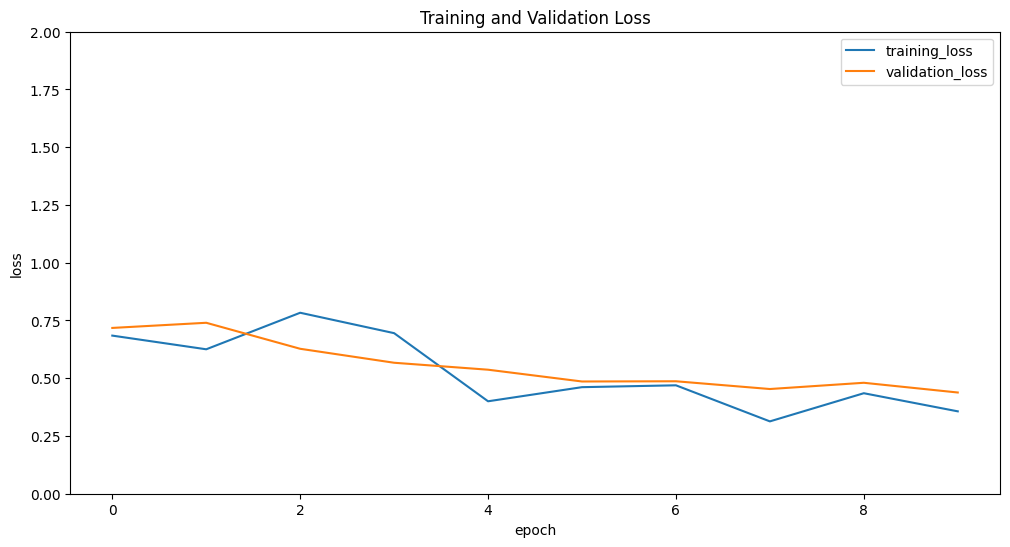

In [29]:
plt.figure(figsize=(12,6))
sns.lineplot(data=train_metrics, x='epoch', y='training_loss', label='training_loss', errorbar=None)
sns.lineplot(data=val_metrics, x='epoch',y='validation_loss', label='validation_loss')
plt.legend()
plt.ylim(0, 2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation Accuracy')

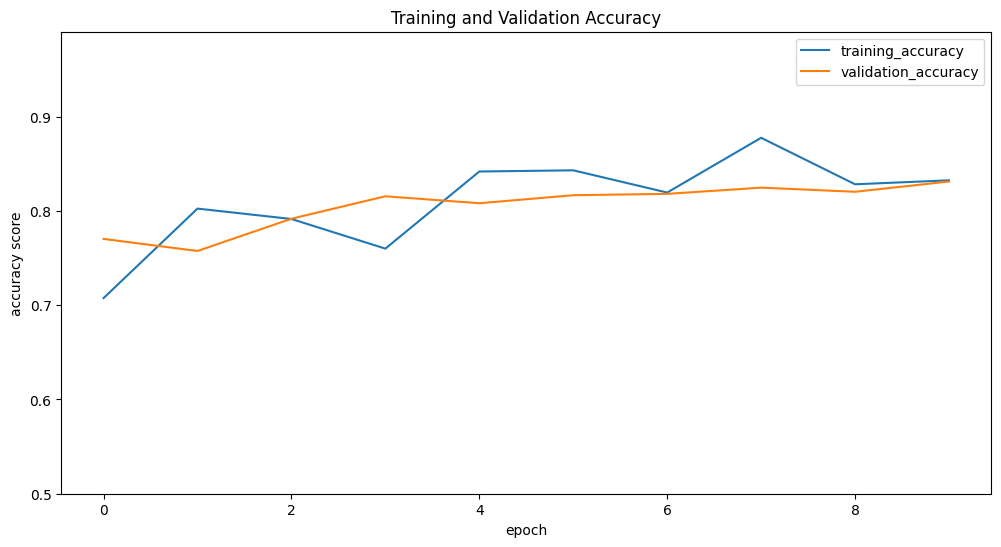

In [28]:
plt.figure(figsize=(12,6))
sns.lineplot(data=train_metrics, x='epoch', y='training_accuracy', label='training_accuracy', errorbar=None)
sns.lineplot(data=val_metrics, x='epoch',y='validation_accuracy', label='validation_accuracy')
plt.legend()
plt.ylim(0.5, 0.99)
plt.ylabel('accuracy score')
plt.xlabel('epoch')
plt.title('Training and Validation Accuracy')

In [20]:
from PIL import Image

In [21]:
my_tester = Image.open(os.path.join(os.getcwd(), 'drive/MyDrive/garbage/random_plastic.jpeg')).convert('RGB')

In [22]:
my_tester = data_transforms['TEST'](my_tester)
my_tester.unsqueeze_(0)
my_tester.shape

torch.Size([1, 3, 150, 300])

In [23]:
with torch.no_grad():
  pred = model(my_tester)
  _, predicted_class = torch.max(pred, 1)
  print(predicted_class)

tensor([8])


In [24]:
class_dict = {0:'PET',
 1:'books_and_paper',
 2:'cans',
 3:'cardboard',
 4:'clothes',
 5:'danger',
 6:'glass_bin',
 7:'metal',
 8:'nonburn',
 9:'plastic'}

In [26]:
print(f'Predicted sorting: {class_dict[predicted_class.item()]}')

Predicted sorting: nonburn
